# Deep RL tennis agents project

This notebook provides a description of the implementation I submitted for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

We begin starting and inspecting the envinronment and the task then we will proceed training the agents and then we will check how the two agents are playing.

In [1]:
!python -m pip install unityagents
!python -m pip install torch
!python -m pip install numpy
!python -m pip install matplotlib

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
from unityagents import UnityEnvironment
from tennis import *

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env = UnityEnvironment(file_name="resources/Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## Solution - shadow agent
We try to solve the task using an algorithm which trains a DDPG agent [\[1\]](https://arxiv.org/pdf/1509.02971.pdf) which plays against its best version of itself. This is possible as the task is fully collaborative and the two agents are learning the same subtask: send the ball to the opponent. Effectively one agent is a classic DDPG agent while the second agent is updated with a clone of the first whenever the first average score (for 100 episodes) reaches historical maximum.

The DDPG algorigthm includes the following variations with respect to the original proposed version in the paper:
- Gradient norm clipping: the algorithm includes a norm clipping to the update of the critic local network during training
- Exploration noise damping: the OU process providing exploratory noise is decreased proportionally to the difference between the obtained score and a score of 40 (higher than 30 to maintain a certain degree of exploration)

Both variations can be enabled/disabled via the corresponding parameters. These are respectively `clip_grad_norm` passed to `DDPGAgent` constructor and `damp_exploration_noise` passed to the function `train`.

### Neural networks architectures
To solve the task 8 neural networks were used. 4 identical networks were used to implement the local and target neural network for the two actors (2 per agent) and other 4 for the critics (2 per agent). All units used are rectified linear units except for the output units of the actor and the critic.

The actor neural network is made of 2 fully connected hidden layers and has a tanh output to limit the actions values to the [-1,1] range as per task definition. When activated the inputs of the 2 fully connected layers are fed to a batch normalization layer. Network hidden layers both have 128 units.

state [-> batch_norm] -> fc(128) [-> batch_norm] -> fc(128) -> fc with tanh units (4) -> actions

The critic is made of 2 fully connected hidden layers and, as proposed in the ddpg paper, the action vector is fed in the second layer.

state [-> batch_norm] -> fc(128) + actions -> fc(128) -> fc with linear units (1) -> value


The following cell creates the agent and launches the training algorithm from the tennis.py file.

### Hyperparameters description
The DDPG agent parameters description is described in the DDPGAgent constructor
```python
"""
Initialization of the Agent
state_size         (int):   dimension of each state
action_size        (int):   dimension of each action
random_seed        (int):   random seed
buffer_size        (int):   number of samples that the replay buffer can store
batch_size         (int):   number of samples used for learning for each learning step
gamma            (float):   reward discount factor of the MDP problem
tau              (float):   soft update factor, between 0 and 1, varies how fast the target network are updated
lr_actor         (float):   learning rate for the actor
lr_critic        (float):   learning rate for the critic
weight_decay     (float):   weight decay regularization factor
sigma            (float):   OU noise process randomness weight
actor_nn_size  [int,int]:   2 dim array defining the number of units in the actor NN for the two fc layers
critic_nn_size [int,int]:   2 dim array defining the number of units in the critic NN for the two fc layers
batch_norm        (bool):   flag to control the use of batch normalization
clip_grad_norm    (bool):   flag to control the use of critic backprop updated gradient clipping
"""
```

The values chosen to solve this environment are listed in the following cell as arguments of the DDPGAgent constructor.

In [6]:
agent = DDPGAgent(state_size, action_size,
        random_seed = 0,
        buffer_size = int(1e5),
        batch_size = 256,
        gamma = 1,
        tau = 1e-3,
        lr_actor = 1e-4,
        lr_critic = 1e-4,
        weight_decay = 0,
        sigma = 0.1,
        actor_nn_size = [128, 128],
        critic_nn_size = [128,128],
        batch_norm = True,
        clip_grad_norm = True)

scores, avg_scores, std, save_path = train(agent, env,
                                           n_episodes = 5000,
                                           score_window_size = 100,
                                           print_every = 50,
                                           max_score = 0.5,
                                           damp_exploration_noise = False)

Episode 50	Average Score: 0.00	Episode duration 0.64
Episode 100	Average Score: 0.00	Episode duration 0.78
Episode 150	Average Score: 0.00	Episode duration 0.89
Episode 200	Average Score: 0.00	Episode duration 0.85
Episode 250	Average Score: 0.00	Episode duration 0.86
Episode 300	Average Score: 0.00	Episode duration 0.89
Episode 350	Average Score: 0.01	Episode duration 1.02
Episode 400	Average Score: 0.01	Episode duration 1.00
Episode 450	Average Score: 0.00	Episode duration 0.87
Episode 500	Average Score: 0.00	Episode duration 0.89
Episode 550	Average Score: 0.00	Episode duration 0.91
Episode 600	Average Score: 0.00	Episode duration 0.96
Episode 650	Average Score: 0.02	Episode duration 1.23
Episode 700	Average Score: 0.04	Episode duration 1.50
Episode 750	Average Score: 0.03	Episode duration 1.33
Episode 800	Average Score: 0.01	Episode duration 1.06
Episode 850	Average Score: 0.00	Episode duration 0.95
Episode 900	Average Score: 0.00	Episode duration 0.91
Episode 950	Average Score: 0.

we plot the scores during training

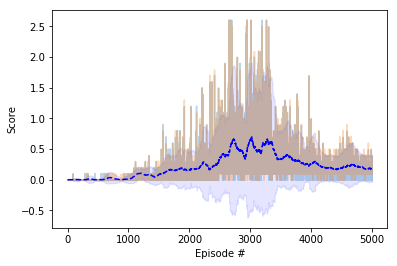

In [11]:
plot_scores(scores, avg_scores, std)

We watch the demo of the trained agent to assess its performances

In [12]:
demo(agent, env, num_episodes=300)

Finally, we close the environment.

In [13]:
env.close()

### Future improvements
The following future improvements should be implemented:

- Test new algorithms such as A2C, A3C, PPO, TRPO instead of DDPG etc...
- Implement a prioritized replay buffer for the critic
- Implement the MADDPG algorithm
- Implement GAE to train the critic
- Try to solve the soccer task
- Optimize hyperparameters further on using, for instance, random sampling